In [220]:
from functions import read_excel, preprocess_dataframe, describe_dataframe
import pandas as pd
import numpy as np
import hashlib
import warnings
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

#Supress warnings
warnings.filterwarnings("ignore")

# Show all columns
pd.set_option('display.max_columns', None)

In [221]:
# Read the data
df1 = read_excel('idtobank.xlsx')
df2 = read_excel('hashtoid.xlsx')
fraud_data = read_excel('fraud.xlsx', sheet_name='Detail data')

df1 = preprocess_dataframe(df1)
df2 = preprocess_dataframe(df2)

df = pd.concat([df1, df2], ignore_index=True)
fraud_ids = fraud_data['customer_id'].unique()
df['is_fraud'] = df['customer_id'].isin(fraud_ids).astype(object)

describe_dataframe(df)

Number of rows: 4063
Number of columns: 57

Column names and data types:
success_redirect_url               object
account_details                    object
expires_at                         object
client                             object
fee                                object
refunded_amount                    object
payment_channel_transaction_id     object
linked_account_id                  object
is_otp_required                    object
otp_mobile_number                  object
settlement_date                    object
failure_code                       object
callback_url                       object
status                             object
channel_account_reference          object
updated                            object
version                            object
checkout_url                       object
vat                                object
client_type                        object
id                                 object
status2                            object
pay

In [222]:
# Preprocessing

# Drop columns that are not useful for the model
drop_columns = [
    'internal_metadata', 'description','mobile_number', 'otp_mobile_number', 'client_reference',
    'version', 'entity', 'type', 'client', 'status2', 'given_names', 'transacting_entity', 'connector_metadata',
    'refunded_amount', 'vat','currency', 'is_otp_required','fee']

df = df.drop(columns=drop_columns)

In [223]:


# Convert 'is_fraud' to numeric (boolean to int)
df['is_fraud'] = df['is_fraud'].astype(int)
print(df.columns)

# Handle categorical variables with one-hot encoding
categorical_cols = ['status', 'client_type', 'channel_code', 'required_action', 'account_type', 'enable_otp']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)




Index(['success_redirect_url', 'account_details', 'expires_at',
       'payment_channel_transaction_id', 'linked_account_id',
       'settlement_date', 'failure_code', 'callback_url', 'status',
       'channel_account_reference', 'updated', 'checkout_url', 'client_type',
       'id', 'payment_channel_verification_id', 'idempotency_key',
       'ledger_transaction_id', 'time', 'business_id', 'end_customer_id',
       'created', 'middle_name', 'amount', 'email', 'channel_code',
       'failure_redirect_url', 'customer_id', 'required_action', 'surname',
       'payment_channel_reference_id', 'account_hash', 'dt', 'account_type',
       'bank_acc', 'otp_expiration_timestamp', 'payment_method_id',
       'reference_id', 'enable_otp', 'is_fraud'],
      dtype='object')


In [224]:
# Clean up training data
X = df.drop(columns=['is_fraud'])
# Split datetime columns into date and time
datetime_columns = ['expires_at', 'settlement_date', 'updated', 'time', 'created', 'otp_expiration_timestamp']

for col in datetime_columns:
    X[col] = pd.to_datetime(X[col], errors='coerce')  # Convert to datetime, errors='coerce' will convert invalid parsing to NaT

# Extract date and time from datetime columns
for col in datetime_columns:
    if col in X.columns:
        X[f'{col}_date'] = X[col].dt.date
        X[f'{col}_time'] = X[col].dt.time

# Drop the original datetime columns
X.drop(columns=datetime_columns, inplace=True)

# Convert 'amount' to float
X['amount'] = pd.to_numeric(X['amount'], errors='coerce')

# Handle remaining non-numeric values
X.replace('nat', np.nan, inplace=True)
X.fillna(0, inplace=True)  # Fill NaN with 0 or handle missing values as needed

# Function to hash values
def hash_value(value):
    if pd.isna(value):
        return np.nan
    return int(hashlib.sha256(str(value).encode()).hexdigest(), 16) % (10 ** 10)

# Hash all columns that are of object type
object_columns = X.select_dtypes(include=['object']).columns
for col in object_columns:
    X[col] = X[col].apply(hash_value)

# Ensure all columns are numeric
X = X.fillna(0)

X = X.fillna(0)

y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.dtypes)
print(X_train.head())

success_redirect_url                 int64
account_details                      int64
payment_channel_transaction_id       int64
linked_account_id                    int64
failure_code                         int64
callback_url                         int64
channel_account_reference            int64
checkout_url                         int64
id                                   int64
payment_channel_verification_id      int64
idempotency_key                      int64
ledger_transaction_id                int64
business_id                          int64
end_customer_id                      int64
middle_name                          int64
amount                             float64
email                                int64
failure_redirect_url                 int64
customer_id                          int64
surname                              int64
payment_channel_reference_id         int64
account_hash                         int64
dt                                   int64
bank_acc   

Training RandomForest...
RandomForest Accuracy: 0.9664
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       672
           1       0.94      0.99      0.96       547

    accuracy                           0.97      1219
   macro avg       0.96      0.97      0.97      1219
weighted avg       0.97      0.97      0.97      1219


Training LogisticRegression...
LogisticRegression Accuracy: 0.7801
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       672
           1       0.76      0.74      0.75       547

    accuracy                           0.78      1219
   macro avg       0.78      0.78      0.78      1219
weighted avg       0.78      0.78      0.78      1219


Training SVC...
SVC Accuracy: 0.8523
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       672
           1       0.86      0.80      0.83       547

    accuracy         

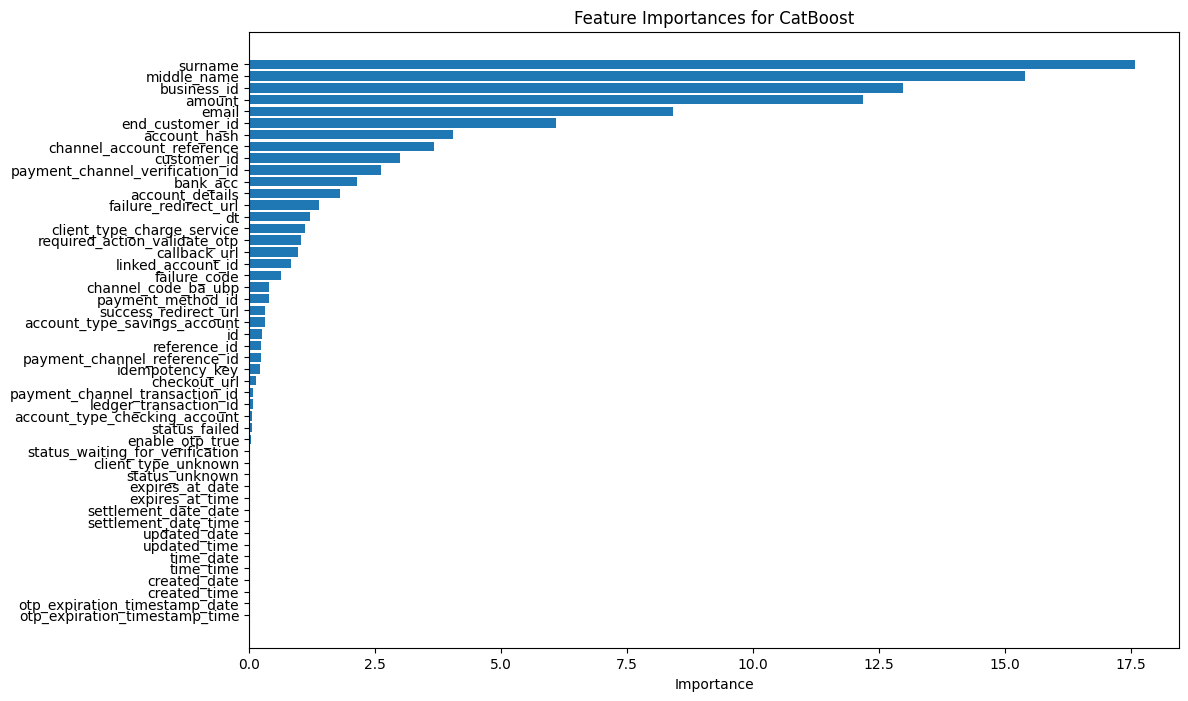

In [225]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(),
    'KNN': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

# Dictionary to store the results and feature importances
results = {}
importances = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print()
    
    # Determine feature importance
    if name in ['RandomForest', 'GradientBoosting', 'CatBoost']:
        # For these models, get feature importances
        if name == 'CatBoost':
            importances[name] = model.get_feature_importance()
        else:
            importances[name] = model.feature_importances_
    elif name == 'LogisticRegression':
        # For LogisticRegression, use coefficients as feature importance
        importances[name] = np.abs(model.coef_[0])
    elif name == 'SVC':
        # SVC does not provide feature importance directly
        importances[name] = None
    elif name == 'KNN':
        # KNeighborsClassifier does not provide feature importance directly
        importances[name] = None

# Identify the best model based on accuracy
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]

print(f"The best model is {best_model_name} with an accuracy of {best_model_accuracy:.4f}")

# Display feature importance for the best model if applicable
if best_model_name in importances and importances[best_model_name] is not None:
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances[best_model_name]
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("Feature Importances for the best model:")
    print(importance_df)
    
    # Plot feature importances if applicable
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importances for {best_model_name}')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()
else:
    print("The best model does not have feature importances.")

Probability of surname 'tan' given transaction is fraud: 0.0323
Probability of surname 'tan' given transaction is not fraud: 0.0026
